In [1]:
import os
from glob import glob

from typing import Dict, List, Tuple
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import dask.array as da
import omnialigner as om
from omnialigner.omni_3D import Omni3D

from omnialigner.cache_files import StageSampleTag, StageTag
from tqdm import tqdm
plt = om.pl.plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
config_file = "/cluster/home/bqhu_jh/projects/omni/config/fair/config_liver.yaml"

om_data = Omni3D(config_info=config_file)
overwrite_cache=False


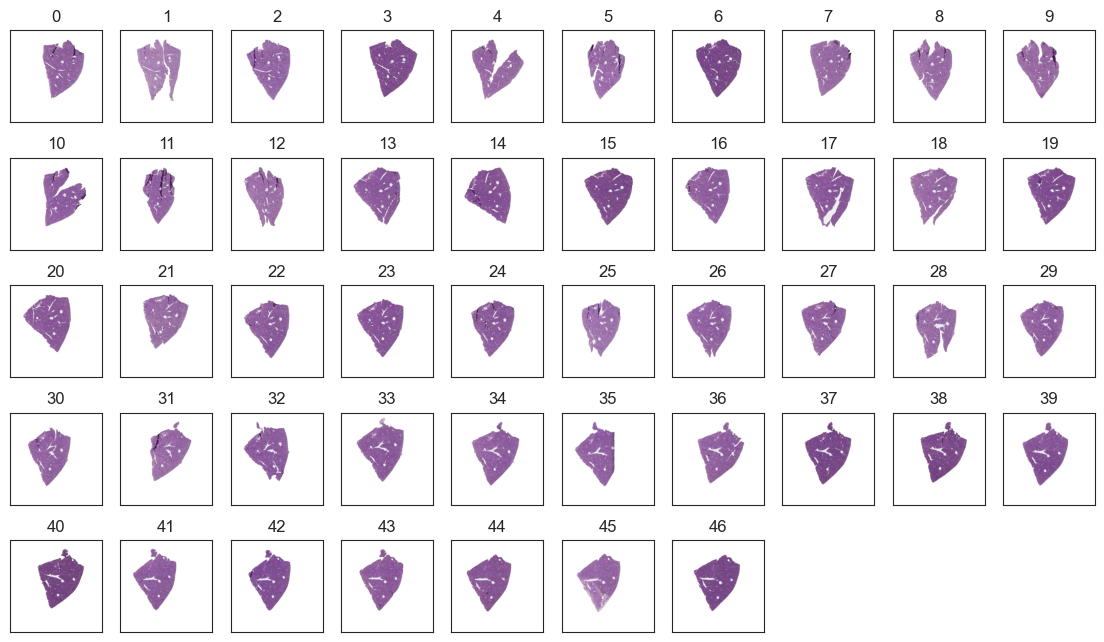

In [3]:
om.pp.pad(om_data,  overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="PAD")

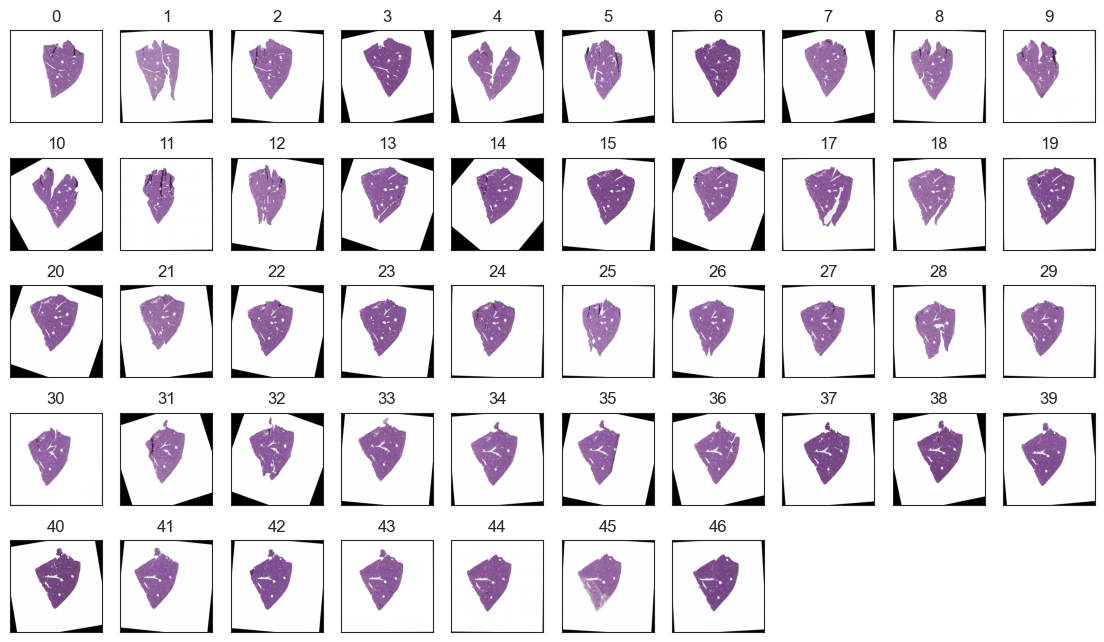

In [6]:

om.align.stack(om_data,  overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="STACK")


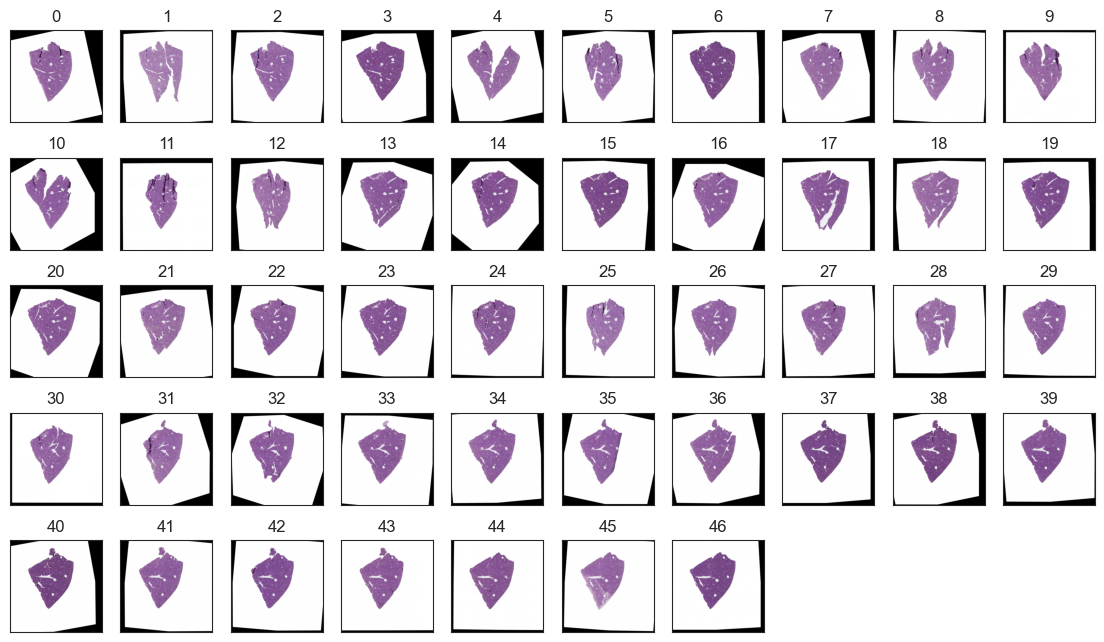

In [7]:
om.align.affine(om_data, overwrite_cache=overwrite_cache)
om.pl.plot_nchw_2d(om_data, aligned_tag="AFFINE")


### optional, fiducial keypoints

download FAIR data from [Fairdata.fi](https://etsin.fairdata.fi/dataset/c76335fa-cdcf-4ddc-ab1c-1882bad82861)

save fiducial keypoints to `l_kpt_pairs_liver.pth`

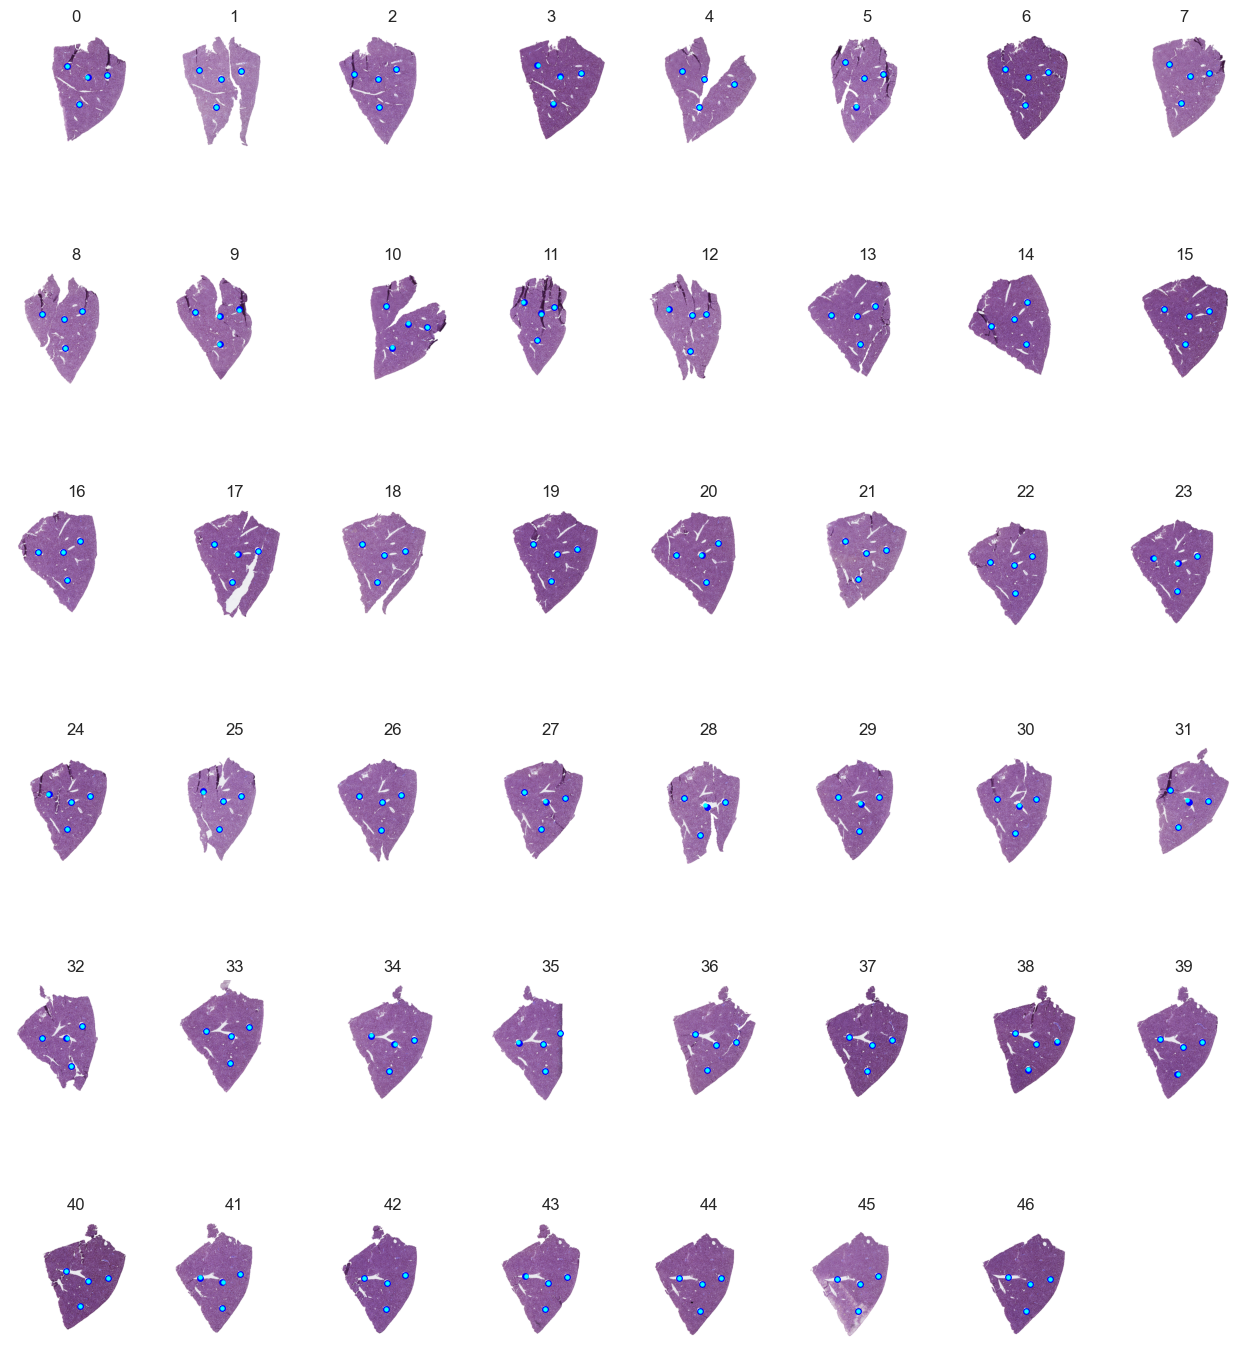

In [ ]:
import pandas as pd

df_o1_csv = pd.read_csv("/cluster/home/bqhu_jh/projects/scGaussian3dGen/data/SupplementaryData_A_comparison_of_reconstruction_algorithms_for_3D_histology/Data_to_IDA/fiducialcoordinates_liver_observer1.txt", sep="\t")

df_o2_csv = pd.read_csv("/cluster/home/bqhu_jh/projects/scGaussian3dGen/data/SupplementaryData_A_comparison_of_reconstruction_algorithms_for_3D_histology/Data_to_IDA/fiducialcoordinates_liver_observer2.txt", sep="\t")
zoom_level = 3


fig = plt.figure(figsize=(16, 18))


i_layer = 0
idx = 0
l_kpt_pairs = []
for i_layer, idx in enumerate(range(len(om_data))):
    ax = fig.add_subplot(6, 8, i_layer+1)
    da_arr_0 = om_data.load_tiff(idx, zoom_level=zoom_level)

    da_out = da_arr_0.compute()
    ax.imshow(da_out)

    np_line1 = df_o1_csv.iloc[idx].values[1:9]
    np_kpts1 = np_line1.reshape(-1, 2)[0:4]
    np_line2 = df_o2_csv.iloc[idx].values[1:9]
    np_kpts2 = np_line2.reshape(-1, 2)[0:4]
    np_kpts = np.vstack([np_kpts1, np_kpts2])
    ax.scatter(np_kpts1[:, 1]*om_data.sizes[zoom_level], np_kpts1[:, 0]*om_data.sizes[zoom_level], c="blue", s=15)
    ax.scatter(np_kpts2[:, 1]*om_data.sizes[zoom_level], np_kpts2[:, 0]*om_data.sizes[zoom_level], c="cyan", s=5)
    ax.set_title(f"{idx}")
    ax.axis("off")
    
    if idx < len(om_data)-1:
        np_line1_ = df_o1_csv.iloc[idx+1].values[1:9]
        np_kpts1_ = np_line1_.reshape(-1, 2)[0:4]
        np_line2_ = df_o2_csv.iloc[idx+1].values[1:9]
        np_kpts2_ = np_line2_.reshape(-1, 2)[0:4]
        np_k1 = np.vstack([np_kpts1])
        np_k2 = np.vstack([np_kpts1_])

    l_kpt_pairs.append([np_kpts[:, ::-1].astype(np.float32)])



torch.save(l_kpt_pairs, "./l_kpt_pairs_liver.pth")


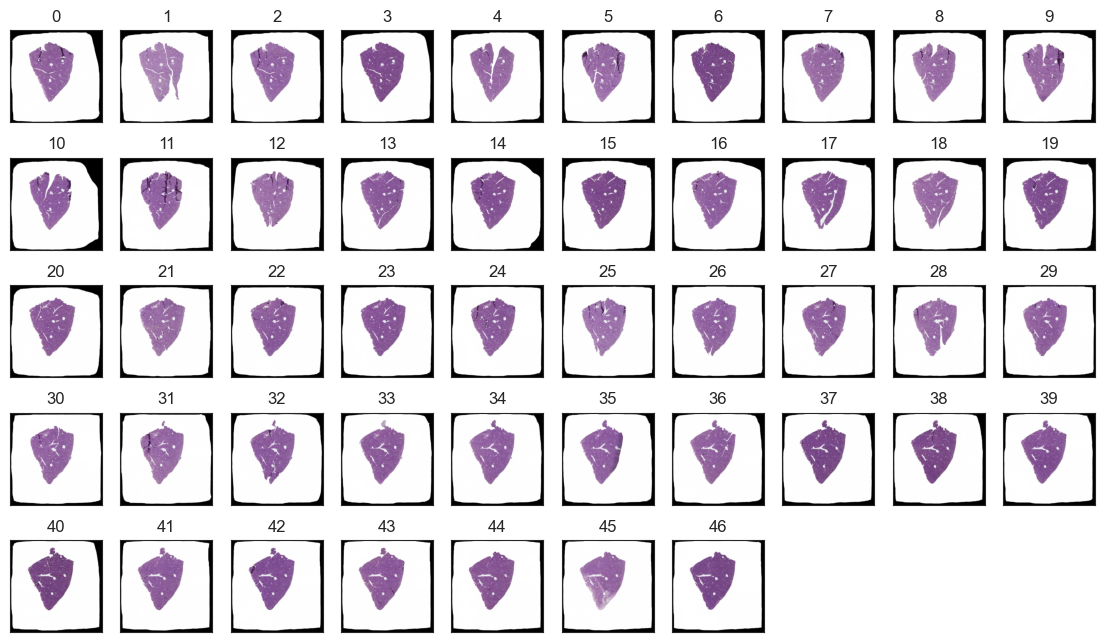

In [11]:
l_kpt_pairs = torch.load("./l_kpt_pairs_liver.pth")

om.align.nonrigid(om_data, overwrite_cache=overwrite_cache, dense_dist_z=1, l_kpts_eval=l_kpt_pairs)
om.pl.plot_nchw_2d(om_data, aligned_tag="NONRIGID")


torch.Size([152, 2])
torch.Size([10152, 2])


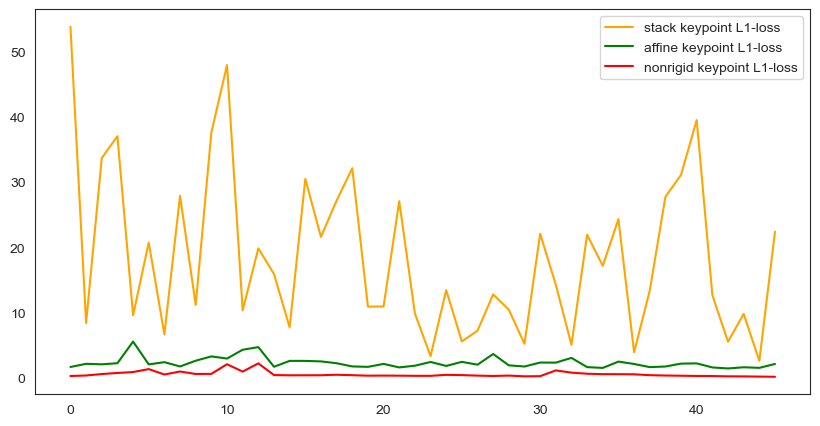

In [12]:
func_loss = lambda pair : torch.mean(torch.abs((pair[0] - pair[1])))
dict_file_name = StageTag.STACK.get_file_name(om_data.proj_info)
l_kpts = torch.load(dict_file_name["l_kpts_pairs"])
loss_kpts_stack = []
for idx_F in range(len(l_kpts)):    
    loss_kpts_stack.append(func_loss(l_kpts[idx_F]))


func_loss = lambda pair : torch.mean(torch.abs((pair[0]*om_data.max_size - pair[1]*om_data.max_size)))
dict_file_name = StageTag.AFFINE.get_file_name(om_data.proj_info)
l_kpts = torch.load(dict_file_name["affine_kpts"])
loss_kpts_affine = []
print(l_kpts[0][0][0].shape)
for idx_F in range(len(l_kpts)):
    loss_kpts_affine.append(func_loss(l_kpts[idx_F][0]))



dict_file_name = StageTag.NONRIGID.get_file_name(om_data.proj_info)
l_kpts = torch.load(dict_file_name["nonrigid_kpts"])
loss_kpts_nonrigid = []
print(l_kpts[0][0][0].shape)
for idx_F in range(len(l_kpts)):
    loss_kpts_nonrigid.append(func_loss(l_kpts[idx_F][0]))
    
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(loss_kpts_stack, label='stack keypoint L1-loss', color="orange")
ax1.plot(loss_kpts_affine, label='affine keypoint L1-loss', color="green")
ax1.plot(loss_kpts_nonrigid, label='nonrigid keypoint L1-loss', color="red")
ax1.legend()

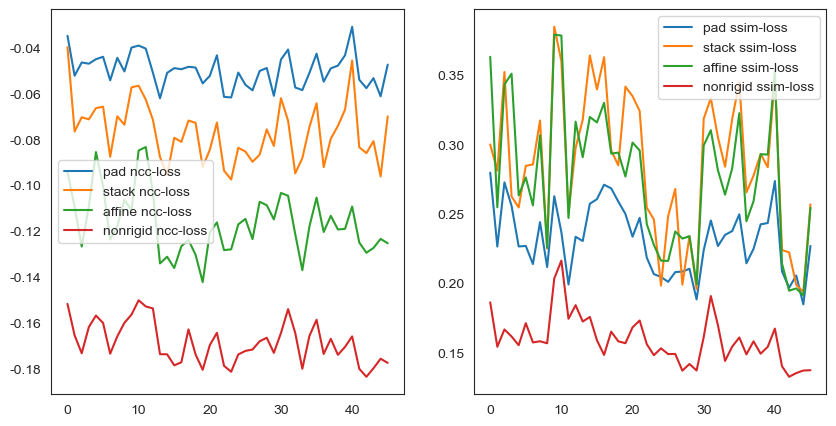

In [13]:
from omnialigner.align.models.loss import ncc_local, ssim_loss
def evaluate_image_loss(om_data: Omni3D, loss_image_func=ncc_local) -> Dict[StageTag, List[float]]:
    dict_loss_img = {}
    for stage in [StageTag.PAD, StageTag.STACK, StageTag.AFFINE, StageTag.NONRIGID]: 
        dict_file_name = stage.get_file_name(om_data.proj_info)
        padded_tensor = torch.load(dict_file_name["padded_tensor"])
        loss_img = []
        for idx_F in range(len(padded_tensor)-1):    
            loss_img.append(loss_image_func(padded_tensor[idx_F:idx_F+1], padded_tensor[idx_F+1:idx_F+2]))
        
        dict_loss_img[stage] = loss_img

    return dict_loss_img

dict_loss_img = evaluate_image_loss(om_data, ncc_local)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(dict_loss_img[StageTag.PAD], label='pad ncc-loss')
ax1.plot(dict_loss_img[StageTag.STACK], label='stack ncc-loss')
ax1.plot(dict_loss_img[StageTag.AFFINE], label='affine ncc-loss')
ax1.plot(dict_loss_img[StageTag.NONRIGID], label='nonrigid ncc-loss')
ax1.legend()


dict_loss_img = evaluate_image_loss(om_data, ssim_loss)    
ax2 = fig.add_subplot(1,2,2)
ax2.plot(dict_loss_img[StageTag.PAD], label='pad ssim-loss')
ax2.plot(dict_loss_img[StageTag.STACK], label='stack ssim-loss')
ax2.plot(dict_loss_img[StageTag.AFFINE], label='affine ssim-loss')
ax2.plot(dict_loss_img[StageTag.NONRIGID], label='nonrigid ssim-loss')
ax2.legend()

In [ ]:
l_img_rgba = om.pl.generte_3d_rgba(om_data)
plt.imshow(l_img_rgba[3])

 21%|███████████████████▊                                                                         | 10/47 [00:08<00:26,  1.41it/s]

In [19]:
om.pl.plot_stack_rgba(l_img_rgba, down_scale=2)

47it [00:00, 241.25it/s]


Widget(value='<iframe src="/proxy/33027/index.html?ui=P_0x7fc9182800a0_2&reconnect=auto" class="pyvista" style…